In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

from filaments.plot import *
from filaments.clustering import *
from filaments.processing import *

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors

from kneed import KneeLocator

# Study of clustering - South China Sea

In [3]:
path = "../../data/CAL/"
image_path = "../../immagini/CAL/"

In [4]:
chl_anomalies = xr.open_dataset(path + "MODIS_chl_anomalies_8D.nc").chlor_a
temp_anomalies = xr.open_dataset(path + "CMEMS_temp_anomalies_8D.nc").analysed_sst
bathy = xr.open_dataset(path + "bathymetry_interpolated.nc")

bathymetry_coast = bathy.where((bathy.elevation >= -1000)).elevation.to_numpy()

lons, lats = chl_anomalies.lon, chl_anomalies.lat

In [5]:
date = "2003-05-17"

chl = bathymetry_filter(chl_anomalies.sel(time = date), bathy)
temp = bathymetry_filter(temp_anomalies.sel(time = date), bathy)

anomalies = prepare_clustering(chl, temp)

# KMeans

c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


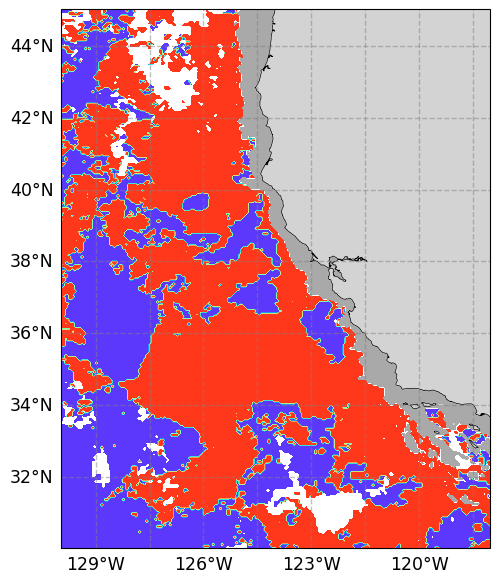

In [39]:
N = 2

labels = KMeans(n_clusters=N).fit_predict(anomalies)

labels_proj = labels_matrix(labels, ~np.isnan(chl))

fig, ax = set_plot()
ax = define_coast(ax, lons, lats, bathymetry_coast)

ax.contourf(lons, lats, labels_proj, cmap = "rainbow")

# DBSCAN

c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


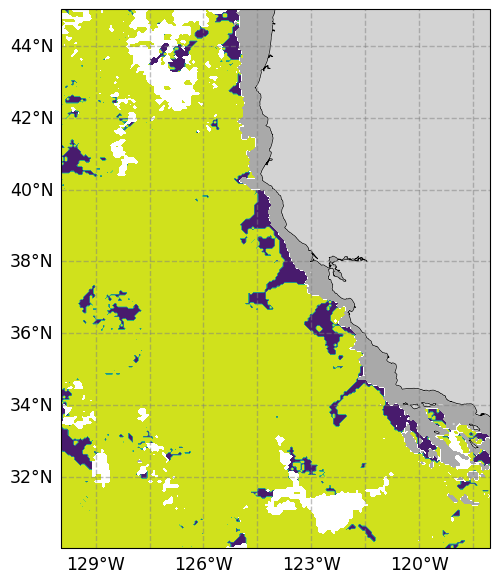

In [40]:
minPts = 1000

nn = NearestNeighbors(n_neighbors=minPts+1).fit(anomalies)

distances, indices = nn.kneighbors(anomalies)

distances = np.sort(distances, axis=0)[:,1:].mean(axis = 1)

eps = KneeLocator(np.arange(0,len(distances)), distances, S=1.0, curve="convex", direction="increasing").elbow_y

mask = ~np.isnan(chl)

labels = DBSCAN(eps=eps, min_samples=minPts).fit_predict(anomalies)

labels_proj = labels_matrix(labels, mask)

fig, ax = set_plot()
ax = define_coast(ax, lons, lats, bathymetry_coast)

ax.contourf(lons, lats, labels_proj)

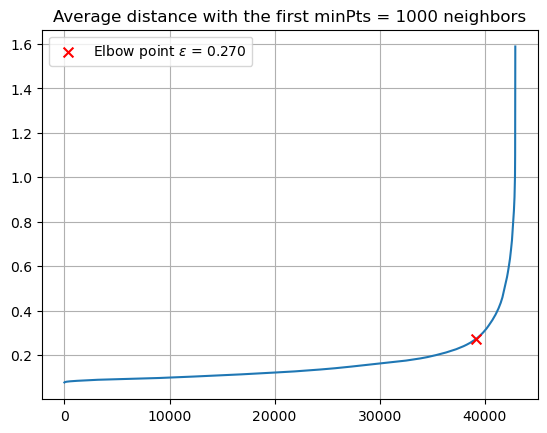

In [41]:
minPts = 1000

nn = NearestNeighbors(n_neighbors=minPts+1).fit(anomalies)

distances, indices = nn.kneighbors(anomalies)

distances = np.sort(distances, axis=0)[:,1:].mean(axis = 1)

eps = KneeLocator(np.arange(0,len(distances)), distances, S=1.0, curve="convex", direction="increasing").elbow_y
x =  KneeLocator(np.arange(0,len(distances)), distances, S=1.0, curve="convex", direction="increasing").elbow

plt.figure()
plt.plot(distances)
plt.title("Average distance with the first minPts = %d neighbors"%(minPts))
plt.scatter(x, eps, marker = "x", color = "red", s = 50, zorder = 2, label = "Elbow point $\epsilon$ = %.3f"%(eps))
plt.legend()
#plt.hlines(eps, xmin = plt.xlim()[0], xmax = plt.xlim()[1], color = "red", linestyles="dashed")
plt.grid()
plt.savefig(image_path + "k-neighbors_DBSCAN.png", bbox_inches = "tight")

## Applying a second clustering to outliers

c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


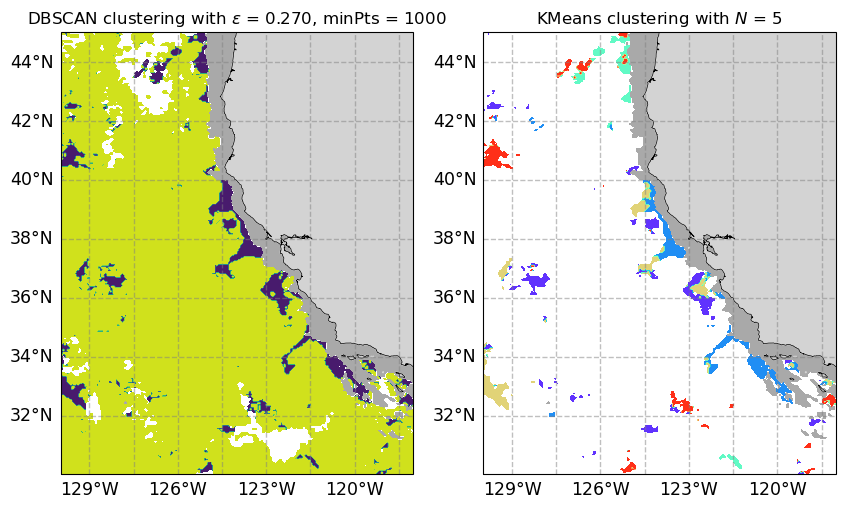

In [6]:
fig, ax = set_plot(ncols=2, figsize = [10,7])
ax = define_coast(ax, lons, lats, bathymetry_coast)

minPts = 1000

nn = NearestNeighbors(n_neighbors=minPts+1).fit(anomalies)

distances, indices = nn.kneighbors(anomalies)

distances = np.sort(distances, axis=0)[:,1:].mean(axis = 1)

eps = KneeLocator(np.arange(0,len(distances)), distances, S=1.0, curve="convex", direction="increasing").elbow_y

mask = ~np.isnan(chl)

first_clustering = DBSCAN(eps=eps, min_samples=minPts).fit_predict(anomalies)

labels_proj = labels_matrix(first_clustering, mask)

ax[0].contourf(lons, lats, labels_proj)

title = "DBSCAN clustering with $\epsilon$ = %.3f, minPts = %d"%(eps, minPts)

ax[0].set_title(title)

#############

outliers = anomalies[first_clustering == -1]

elbow = []
for n in range(2,10):
    elbow.append(KMeans(n_clusters = n).fit(outliers).inertia_)

N = KneeLocator(np.arange(2,len(elbow)+2), elbow, S=1.0, curve="convex", direction="decreasing").elbow

labels = KMeans(n_clusters=N).fit_predict(outliers)

labels_proj[np.where(labels_proj == 0)] = np.nan

labels_proj[~np.isnan(labels_proj)] = labels

ax[1].contourf(lons, lats, labels_proj, cmap = "rainbow")

title = "KMeans clustering with $N$ = %d"%(N)

ax[1].set_title(title)

plt.savefig(image_path + "image_clustered.png", bbox_inches = "tight")

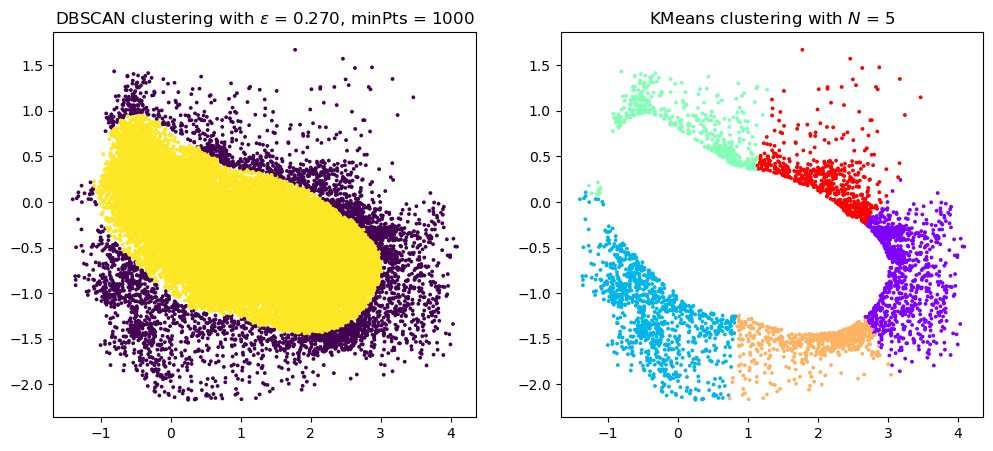

In [7]:
fig, ax = plt.subplots(ncols = 2, figsize = [12,5])

minPts = 1000

nn = NearestNeighbors(n_neighbors=minPts+1).fit(anomalies)

distances, indices = nn.kneighbors(anomalies)

distances = np.sort(distances, axis=0)[:,1:].mean(axis = 1)

eps = KneeLocator(np.arange(0,len(distances)), distances, S=1.0, curve="convex", direction="increasing").elbow_y

mask = ~np.isnan(chl)

first_clustering = DBSCAN(eps=eps, min_samples=minPts).fit_predict(anomalies)

labels_proj = labels_matrix(first_clustering, mask)

ax[0].scatter(anomalies[:,0], anomalies[:,1], s = 3, cmap = "viridis", c = first_clustering)

title = "DBSCAN clustering with $\epsilon$ = %.3f, minPts = %d"%(eps, minPts)

ax[0].set_title(title)
###############

outliers = anomalies[first_clustering == -1]

# elbow = []
# for n in range(2,10):
#     elbow.append(KMeans(n_clusters = n).fit(outliers).inertia_)

# N = KneeLocator(np.arange(2,len(elbow)+2), elbow, S=1.0, curve="convex", direction="decreasing").elbow

# labels = KMeans(n_clusters=N).fit_predict(outliers)

ax[1].scatter(outliers[:,0], outliers[:,1], s = 3, c = labels, cmap = "rainbow" )

title = "KMeans clustering with $N$ = %d"%(N)

ax[1].set_title(title)

plt.savefig(image_path + "clustering_scatterplot_CAL.png", bbox_inches = "tight")

# Eps values and fraction of points clustered as noise

In [44]:
minPts = 1000

n_list = []
frac_list = []
eps_list = []

for (t, chl, temp) in zip(chl_anomalies.time.to_numpy(), chl_anomalies.to_numpy(), temp_anomalies.to_numpy()):

    chl, temp = bathymetry_filter(chl, bathy), bathymetry_filter(temp, bathy)

    im = prepare_clustering(chl, temp)

    if len(im) <= minPts:
        n_list.append(np.nan)
        frac_list.append(np.nan)
        eps_list.append(np.nan)
        print("Not enough points")
        pass

    else:

        distances, _ = NearestNeighbors(n_neighbors=minPts+1).fit(im).kneighbors(im)

        distances = np.sort(distances, axis=0)[:,1:].mean(axis = 1)

        eps = KneeLocator(np.arange(0,len(distances)), distances, S=1.0, curve="convex", direction="increasing").elbow_y

        labels = DBSCAN(eps=eps, min_samples=minPts).fit_predict(im)

        n_list.append(len(np.unique(labels)))
        frac_list.append(len(labels[labels == -1])/len(labels))
        eps_list.append(eps)

        print("%s \t eps = %.3f \t f = %.3f \t n = %d"%(t, eps_list[-1], frac_list[-1], n_list[-1]))

2003-01-01T00:00:00.000000000 	 eps = 0.310 	 f = 0.088 	 n = 2
2003-01-09T00:00:00.000000000 	 eps = 0.357 	 f = 0.109 	 n = 2
2003-01-17T00:00:00.000000000 	 eps = 0.327 	 f = 0.143 	 n = 2
2003-01-25T00:00:00.000000000 	 eps = 0.408 	 f = 0.150 	 n = 2
2003-02-02T00:00:00.000000000 	 eps = 0.329 	 f = 0.083 	 n = 2
2003-02-10T00:00:00.000000000 	 eps = 0.309 	 f = 0.077 	 n = 2
2003-02-18T00:00:00.000000000 	 eps = 0.289 	 f = 0.103 	 n = 2
2003-02-26T00:00:00.000000000 	 eps = 0.283 	 f = 0.131 	 n = 2
2003-03-06T00:00:00.000000000 	 eps = 0.293 	 f = 0.102 	 n = 2
2003-03-14T00:00:00.000000000 	 eps = 0.234 	 f = 0.132 	 n = 2
2003-03-22T00:00:00.000000000 	 eps = 0.254 	 f = 0.117 	 n = 2
2003-03-30T00:00:00.000000000 	 eps = 0.295 	 f = 0.089 	 n = 2
2003-04-07T00:00:00.000000000 	 eps = 0.283 	 f = 0.093 	 n = 2
2003-04-15T00:00:00.000000000 	 eps = 0.278 	 f = 0.109 	 n = 2
2003-04-23T00:00:00.000000000 	 eps = 0.293 	 f = 0.067 	 n = 2
2003-05-01T00:00:00.000000000 	 eps = 0.

In [46]:
np.savetxt(path + "eps_err.txt", np.array([eps_list, frac_list, n_list]))

In [30]:
eps_err = np.genfromtxt(path + "eps_err.txt")
time = chl_anomalies.time.to_numpy()

np.asarray([[t, e, f, n] for (t, e, f, n) in zip(time, eps_err[0], eps_err[1], eps_err[2])])



array([[numpy.datetime64('2003-01-01T00:00:00.000000000'),
        0.31017154529609126, 0.08758172822053366, 2.0],
       [numpy.datetime64('2003-01-09T00:00:00.000000000'),
        0.35696608295666443, 0.108530921535077, 2.0],
       [numpy.datetime64('2003-01-17T00:00:00.000000000'),
        0.32683713448983, 0.14287489437844822, 2.0],
       ...,
       [numpy.datetime64('2021-12-03T00:00:00.000000000'),
        0.37793226857125894, 0.10383989345960343, 2.0],
       [numpy.datetime64('2021-12-11T00:00:00.000000000'),
        0.3389823168131485, 0.0843984730944465, 2.0],
       [numpy.datetime64('2021-12-19T00:00:00.000000000'),
        0.38121068219568655, 0.09146570036236411, 2.0]], dtype=object)

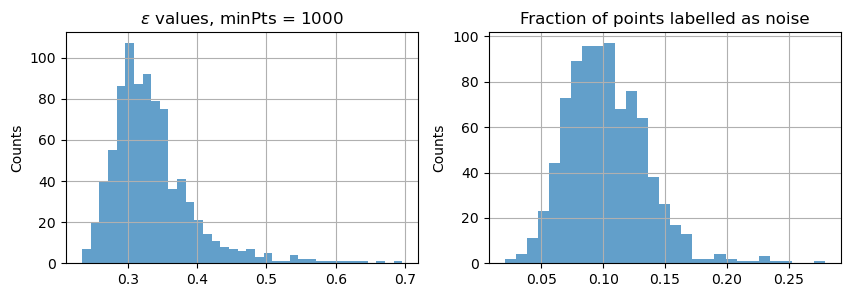

In [6]:
eps_err = np.genfromtxt(path + "eps_err.txt")

fig, ax = plt.subplots(ncols = 2, figsize = [10,3])

ax[0].hist(eps_err[0][:], bins = "auto", alpha = 0.7)
ax[0].set_title("$\epsilon$ values, minPts = %d"%(1000))
ax[0].set_ylabel("Counts")
ax[0].grid()

ax[1].hist(eps_err[1][:], bins = "auto", alpha = 0.7)
ax[1].set_title("Fraction of points labelled as noise")
ax[1].set_ylabel("Counts")
ax[1].grid()

plt.savefig(image_path + "eps_noise_distribution.png", bbox_inches = "tight")

c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecate

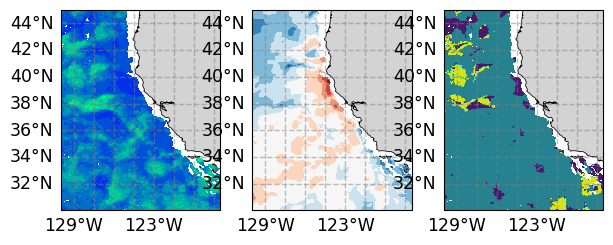

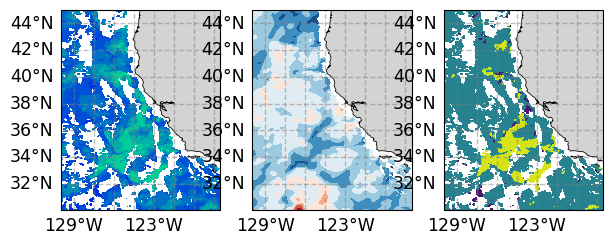

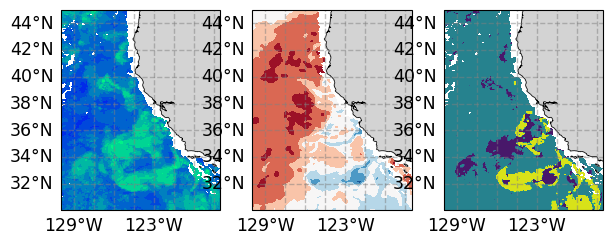

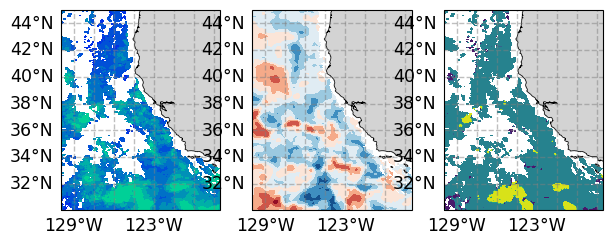

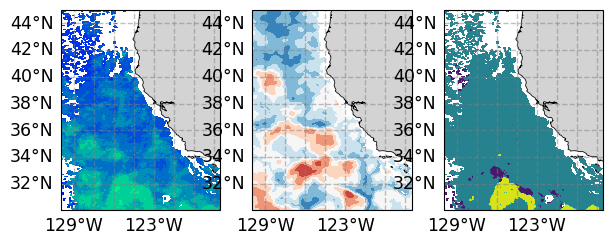

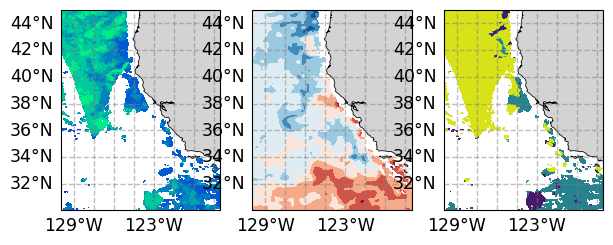

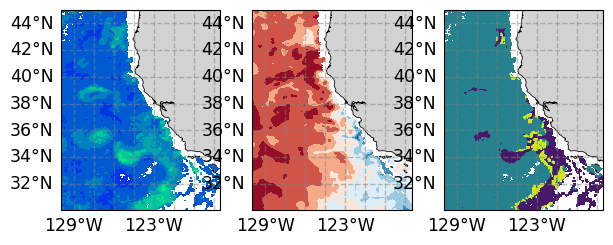

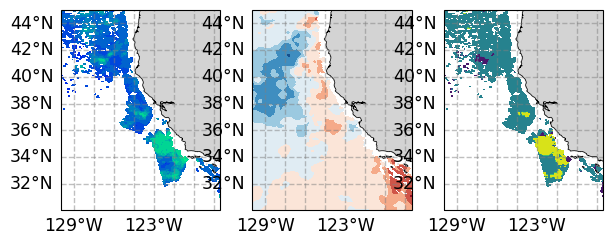

In [20]:
time = chl_anomalies.time.to_numpy()

three_clusters = time[eps_err[2][:] == 3]

for t in three_clusters:

    chl = bathymetry_filter(chl_anomalies.sel(time = t), bathy)
    temp = bathymetry_filter(temp_anomalies.sel(time = t), bathy)
    anomalies = prepare_clustering(chl, temp)

    minPts = 1000

    nn = NearestNeighbors(n_neighbors=minPts+1).fit(anomalies)

    distances, indices = nn.kneighbors(anomalies)

    distances = np.sort(distances, axis=0)[:,1:].mean(axis = 1)

    eps = KneeLocator(np.arange(0,len(distances)), distances, S=1.0, curve="convex", direction="increasing").elbow_y

    mask = ~np.isnan(chl)

    labels = DBSCAN(eps=eps, min_samples=minPts).fit_predict(anomalies)

    labels_proj = labels_matrix(labels, mask)

    fig, ax = set_plot(ncols = 3)

    ax[0].contourf(lons, lats, chl, cmap = "winter")
    ax[1].contourf(lons, lats, temp, cmap = "RdBu_r")
    ax[2].contourf(lons, lats, labels_proj)

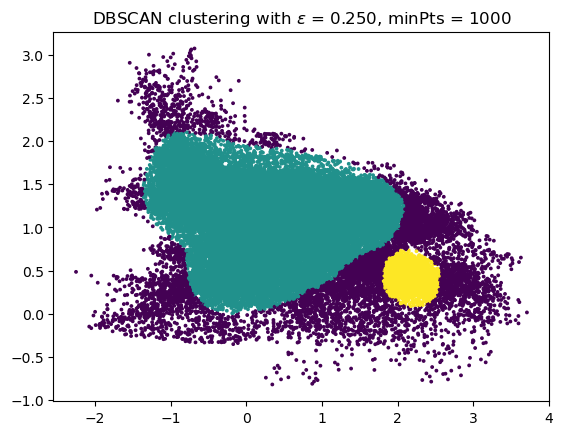

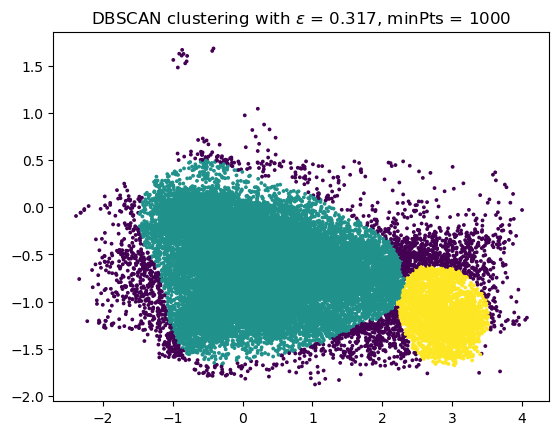

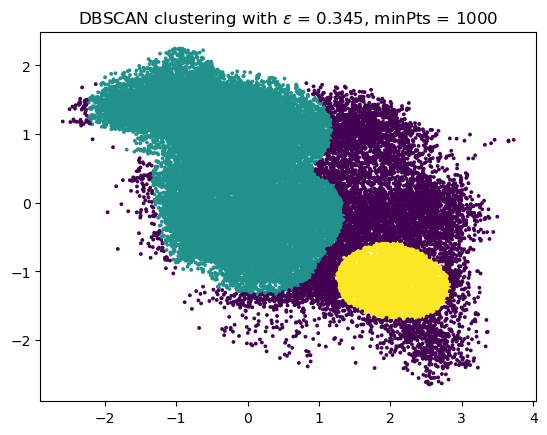

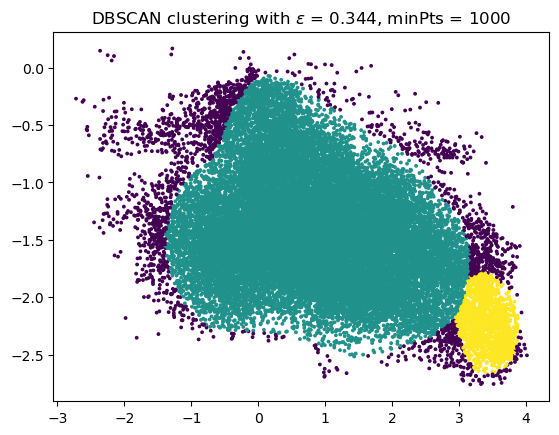

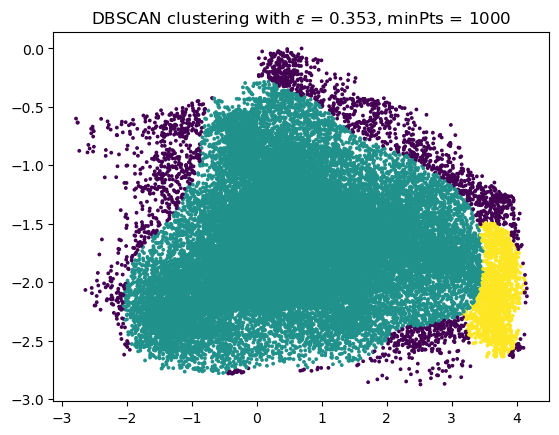

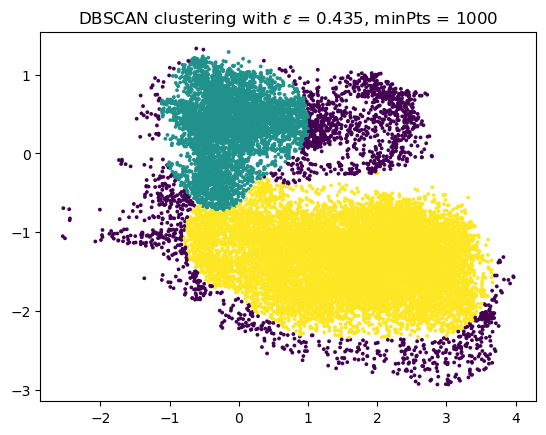

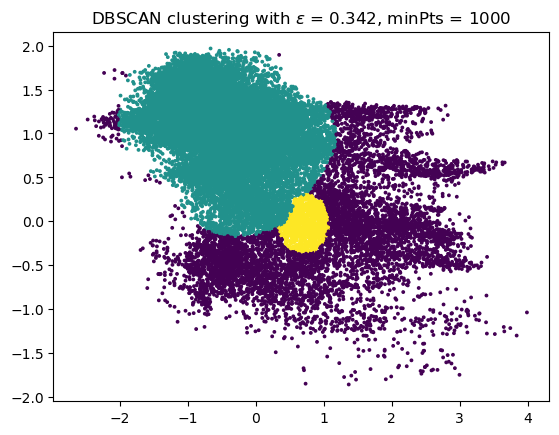

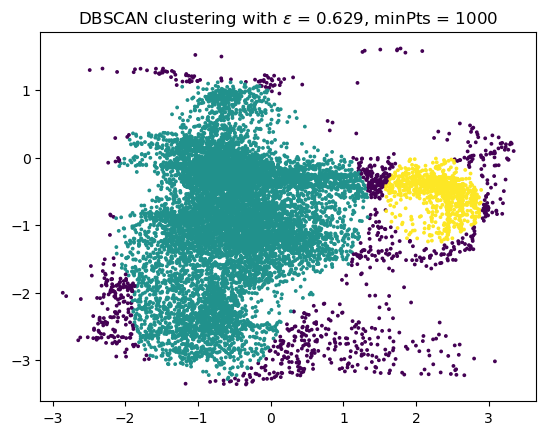

In [23]:
time = chl_anomalies.time.to_numpy()

three_clusters = time[eps_err[2][:] == 3]

for t in three_clusters:

    chl = bathymetry_filter(chl_anomalies.sel(time = t), bathy)
    temp = bathymetry_filter(temp_anomalies.sel(time = t), bathy)
    anomalies = prepare_clustering(chl, temp)

    minPts = 1000

    nn = NearestNeighbors(n_neighbors=minPts+1).fit(anomalies)

    distances, indices = nn.kneighbors(anomalies)

    distances = np.sort(distances, axis=0)[:,1:].mean(axis = 1)

    eps = KneeLocator(np.arange(0,len(distances)), distances, S=1.0, curve="convex", direction="increasing").elbow_y

    mask = ~np.isnan(chl)

    labels = DBSCAN(eps=eps, min_samples=minPts).fit_predict(anomalies)

    minPts = 1000

    plt.figure()

    plt.scatter(anomalies[:,0], anomalies[:,1], s = 3, cmap = "viridis", c = labels)

    title = "DBSCAN clustering with $\epsilon$ = %.3f, minPts = %d"%(eps, minPts)

    plt.title(title)


c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
c:\Users\feder\miniconda3\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


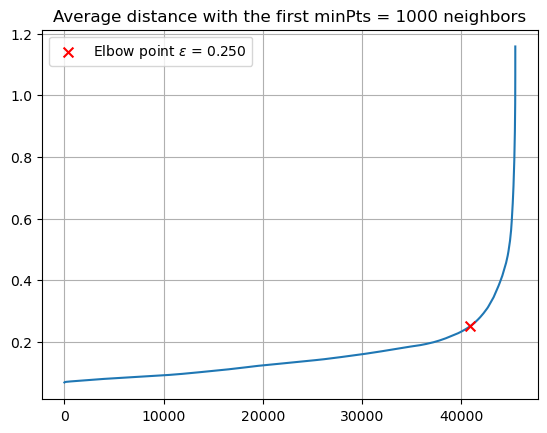

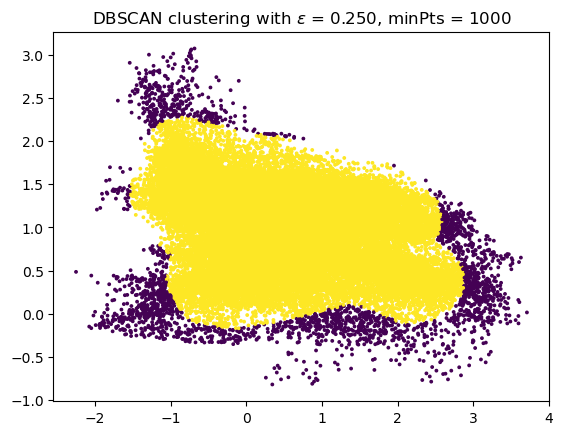

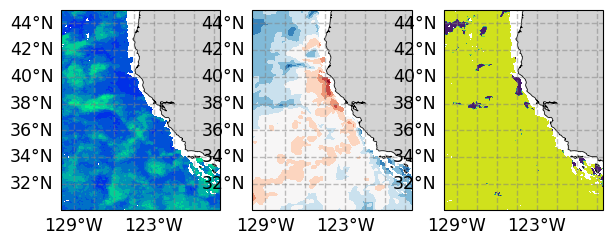

In [35]:

three_clusters = time[eps_err[2][:] == 3]

chl = bathymetry_filter(chl_anomalies.sel(time = three_clusters[0]), bathy)
temp = bathymetry_filter(temp_anomalies.sel(time = three_clusters[0]), bathy)
anomalies = prepare_clustering(chl, temp)


minPts = 1000

nn = NearestNeighbors(n_neighbors=minPts+1).fit(anomalies)

distances, _ = nn.kneighbors(anomalies)

distances = np.sort(distances, axis=0)[:,1:].mean(axis = 1)

eps = KneeLocator(np.arange(0,len(distances)), distances, curve="convex", direction="increasing").elbow_y
x =  KneeLocator(np.arange(0,len(distances)), distances, curve="convex", direction="increasing").elbow

plt.figure()
plt.plot(distances)
plt.title("Average distance with the first minPts = %d neighbors"%(minPts))
plt.scatter(x, eps, marker = "x", color = "red", s = 50, zorder = 2, label = "Elbow point $\epsilon$ = %.3f"%(eps))
plt.legend()
#plt.hlines(eps, xmin = plt.xlim()[0], xmax = plt.xlim()[1], color = "red", linestyles="dashed")
plt.grid()

labels = DBSCAN(eps=0.31, min_samples=minPts).fit_predict(anomalies)

plt.figure()

plt.scatter(anomalies[:,0], anomalies[:,1], s = 3, cmap = "viridis", c = labels)

title = "DBSCAN clustering with $\epsilon$ = %.3f, minPts = %d"%(eps, minPts)

plt.title(title)

mask = ~np.isnan(chl)

labels_proj = labels_matrix(labels, mask)

fig, ax = set_plot(ncols = 3)

ax[0].contourf(lons, lats, chl, cmap = "winter")
ax[1].contourf(lons, lats, temp, cmap = "RdBu_r")
ax[2].contourf(lons, lats, labels_proj)

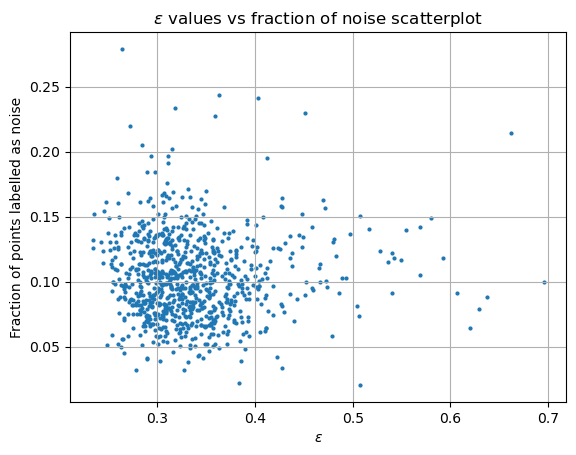

In [48]:
plt.figure()
plt.scatter(eps_err[0][:], eps_err[1][:], s = 4)

plt.title("$\epsilon$ values vs fraction of noise scatterplot")
plt.ylabel("Fraction of points labelled as noise")
plt.xlabel("$\epsilon$")
plt.grid()

plt.savefig(image_path + "eps_frac_scatterplot.png", bbox_inches = "tight")

In [49]:
available_points = []

for i in range(0, len(chl_anomalies)):

    available_points.append(chl_anomalies.to_numpy()[i][~np.isnan(chl_anomalies.to_numpy()[i])].shape[0])

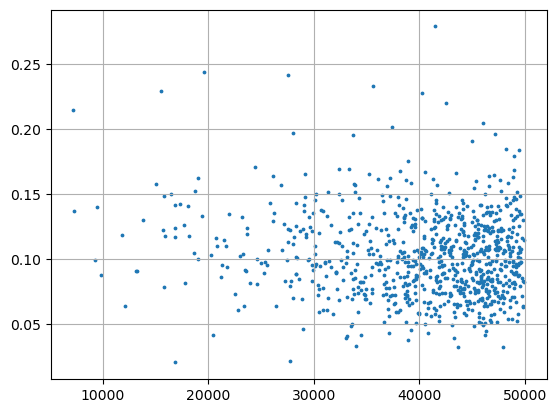

In [50]:
plt.figure()
plt.scatter(available_points, eps_err[1][:], s = 3)
plt.grid()